<br>

### Installing Octopy-Energy

The first step to getting running with the library is to install it through pip.

In [1]:
! pip install octopyenergy

<br>

Once installed `octopyenergy` can be imported into your scripts.

In [1]:
import octopyenergy as oe
from octopyenergy.api import DownloadManager

<br>

### User Inputs

We now need to assign values for our account/meter details.

N.b. we recommend that you store your account details in a `.env` file and then use the `dotenv` library to set them as environment variables, which can in turn be picked up by `os` and assigned to local variables.

In [2]:
octopus_api_key = 'OCTOPUS_API_KEY'
meter_mpan = 'METER_MPAN'
meter_serial = 'METER_SERIAL'

<br>

### Configuring the Download Manager

We'll start by initialising the `DownloadManager`, when we do so we can pass a number of parameters which will configure defaults in the download manager. The `octopus_api_key` is also required for some requests.

In [12]:
download_manager = DownloadManager(meter_mpan=meter_mpan, 
                                   meter_serial=meter_serial, 
                                   api_key=octopus_api_key)

download_manager

Welcome to the octopyenergy DownloadManager! For more information please read the documentation at https://github.com/AyrtonB/Octopy-Energy.

The following API end-points are available: 
retrieve_products, retrieve_product, retrieve_tariff_charges, retrieve_meter_point, retrieve_electricity_consumption, retrieve_gas_consumption, retrieve_gsps


<br>

One of the benefits of specifying these parameters is that they will be used to pre-populate the function docstrings.

In [13]:
help(download_manager.retrieve_meter_point)

Help on function retrieve_meter_point:

retrieve_meter_point(meter_mpan='1012627213444', **kwargs)
    Retrieves a meter-point
    
    Parameters:
        meter_mpan



<br>

Specifying those parameters also reduces the amount of arguments we need to pass when making data requests.

Wall time: 1.03 s


<AxesSubplot:xlabel='interval_start'>

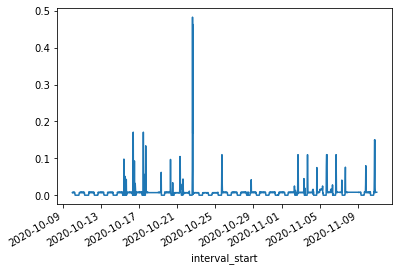

In [14]:
%%time

s_elec_consumption = download_manager.create_elec_consumption_s()

s_elec_consumption.plot()

<br>

A number of the end-points do not require an API key or additional arguments, these will work even when no parameters are specified during the `DownloadManager` initialisation.

In [15]:
download_manager = DownloadManager()

download_manager.retrieve_gsps().json()

{'count': 14,
 'next': None,
 'previous': None,
 'results': [{'group_id': '_A'},
  {'group_id': '_B'},
  {'group_id': '_C'},
  {'group_id': '_D'},
  {'group_id': '_E'},
  {'group_id': '_F'},
  {'group_id': '_G'},
  {'group_id': '_H'},
  {'group_id': '_J'},
  {'group_id': '_K'},
  {'group_id': '_L'},
  {'group_id': '_M'},
  {'group_id': '_N'},
  {'group_id': '_P'}]}

<br>

For those that do an Exception will be raised detailing why the request was unsuccessful.

In [16]:
def request_electricity_consumption(download_manager, meter_mpan=None, meter_serial=None):
    try:
        download_manager.retrieve_electricity_consumption(meter_mpan=meter_mpan, meter_serial=meter_serial)
        print('Successfully retrieved!')

    except oe.api.SadOctopy as err:
        print(err)
        
request_electricity_consumption(download_manager, meter_mpan, meter_serial)

Authentication credentials were not provided.


<br>

This can easily be remedied by calling the `autheticate` method and passing your api key.

In [17]:
download_manager.authenticate(octopus_api_key)

request_electricity_consumption(download_manager, meter_mpan, meter_serial)

Successfully retrieved!


<br>

A similar event may occur if you provided no parameters when the download manager was initialised, then try to call a function that requires one of those parameters for a default. To assign these parameters we can call a method where assign is used as a prefix, e.g. `download_manager.assign_<parameter_name>(<parameter_value>)`.

In [18]:
download_manager.assign_meter_mpan(meter_mpan)
download_manager.assign_meter_serial(meter_serial)

s_elec_consumption = download_manager.create_elec_consumption_s()

s_elec_consumption.head()

interval_start
2020-11-10 23:00:00+00:00    0.008
2020-11-10 22:30:00+00:00    0.008
2020-11-10 22:00:00+00:00    0.008
2020-11-10 21:30:00+00:00    0.008
2020-11-10 21:00:00+00:00    0.008
Name: consumption, dtype: float64

<br>

### Abstraction Levels

So far we've mainly used the `create_elec_consumption_s` method, this is a high-level function in the API that carries out the request and then converts the response into a tidied `pandas` series. Underneath this layer lie several lower-level functions which can provide us additional control.

Here we'll query the `retrieve_electricity_consumption` end-point and extract the JSON response.

In [19]:
r = download_manager.retrieve_electricity_consumption(meter_mpan=meter_mpan, meter_serial=meter_serial)

r.json().keys()

dict_keys(['count', 'next', 'previous', 'results'])

<br>

We can use another `octopyenergy` helper function, `response_to_data` to convert the response into a dataframe.

N.b. this will only work for responses which can be converted into a dataframe, such as those from `retrieve_electricity_consumption` and `retrieve_gas_consumption`. 

In [20]:
s_elec_consumption = oe.api.results_to_df(r.json()['results'])

s_elec_consumption.head()

interval_start
2020-11-10 23:00:00+00:00    0.008
2020-11-10 22:30:00+00:00    0.008
2020-11-10 22:00:00+00:00    0.008
2020-11-10 21:30:00+00:00    0.008
2020-11-10 21:00:00+00:00    0.008
Name: consumption, dtype: float64

<br>

The deepest abstraction level is available through the `query_endpoint` method, this provides access to all of the end-points but requires a larger number of parameters to be passed. The benefit of this level is that it can be easier to work with when the end-point being used is specified through another variable.

In [21]:
end_point = 'retrieve_electricity_consumption'

end_point_kwargs = {
    'meter_mpan': meter_mpan,
    'meter_serial': meter_serial,
}

r = download_manager.query_endpoint(end_point, end_point_kwargs)

r.json().keys()

dict_keys(['count', 'next', 'previous', 'results'])

<br>

One of the issues when working with the direct responses is that we have to iterate through the data pages, we can use a helper method called `retrieve_all_results` to do this for us and return the combined results.

In [22]:
results = download_manager.retrieve_all_results(r)
results_count = len(results)

assert results_count == r.json()['count'], "The full dataset was not returned"

print(results_count)

1441


<br>

### Product Comparisons

We can use `create_products_df` to return a dataframe containing information on all available products.

In [61]:
df_products = download_manager.create_products_df()

df_products.head(3)

,direction,full_name,display_name,description,is_variable,is_green,is_tracker,is_prepay,is_business,is_restricted,term,available_from,available_to,links,brand
code,,,,,,,,,,,,,,,
AFFECT-FIX-12M-20-09-22,IMPORT,Affect 12M Fixed September 2020 v2,Affect 12M Fixed,This tariff features 100% renewable electricit...,False,False,False,False,False,False,12.0,2020-09-22T00:00:00+01:00,None,https://api.octopus.energy/v1/products/AFFECT-...,AFFECT_ENERGY
AFFECT-LOYAL-FIX-12M-20-09-28,IMPORT,Affect Loyal 12M Fixed September 2020 v1,Affect Loyal 12M Fixed,This tariff features 100% renewable electricit...,False,False,False,False,False,False,12.0,2020-09-28T00:00:00+01:00,None,https://api.octopus.energy/v1/products/AFFECT-...,AFFECT_ENERGY
AFFECT-SEG-FIX-12M-20-11-11,EXPORT,Affect Smart Export Guarantee November 2020 v1,Affect Smart Export Guarantee,This is our Smart Export Guarantee compliant e...,False,True,False,False,False,False,12.0,2020-11-11T17:00:00Z,None,https://api.octopus.energy/v1/products/AFFECT-...,AFFECT_ENERGY


<br>

Having all of the products in a dataframe allows us to more easily ask questions such as what percentage of the products are green or what is the product count by brand.

In [59]:
green_pct = df_products.query('is_green == True').shape[0]/df_products.shape[0]

print(f'{green_pct:.2%} of the products are green, \n\nThe brand breakdown is as follows:')
df_products['brand'].value_counts()

34.62% of the products are green, 

The brand breakdown is as follows:


COOP_ENERGY       59
OCTOPUS_ENERGY    32
LONDON_POWER       6
AFFECT_ENERGY      4
HARPER             3
Name: brand, dtype: int64

<br>

We can then retrieve the unit rates for a specific product code using `create_unit_rates_s`.

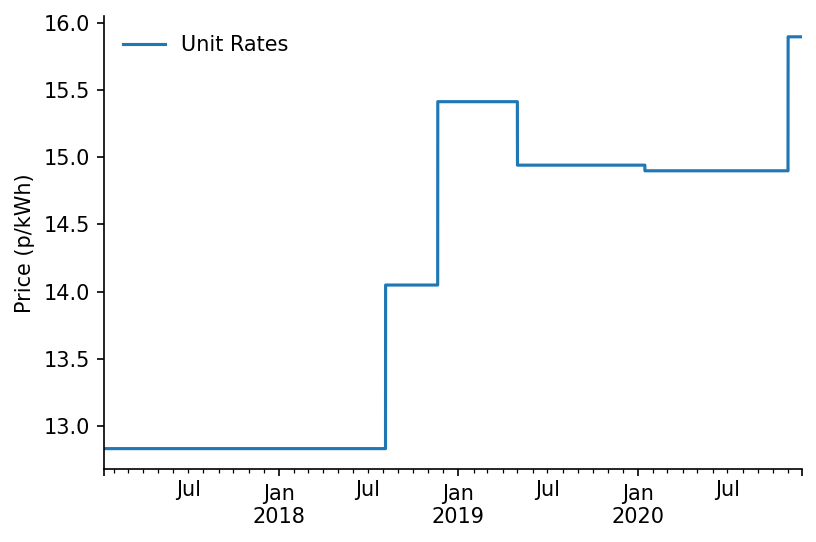

In [40]:
product_code = 'VAR-17-01-11'
tariff_type = 'electricity-tariffs'
tariff_code = f'E-1R-{product_code}-C'
charge_type = 'standard-unit-rates'

s_unit_rates = download_manager.create_unit_rates_s(product_code, tariff_type, 
                                                    tariff_code, charge_type)

fig, ax = octoplot.simple_plot(s_unit_rates, ylabel='Price (p/kWh)')

<br>

It's far more interesting to do a comparison though so we'll also retrieve the agile and go tariffs, then visualise the weekly average unit rates alongside each other.

Text(0.5, 1.0, 'Unit Rate Weekly Averages')

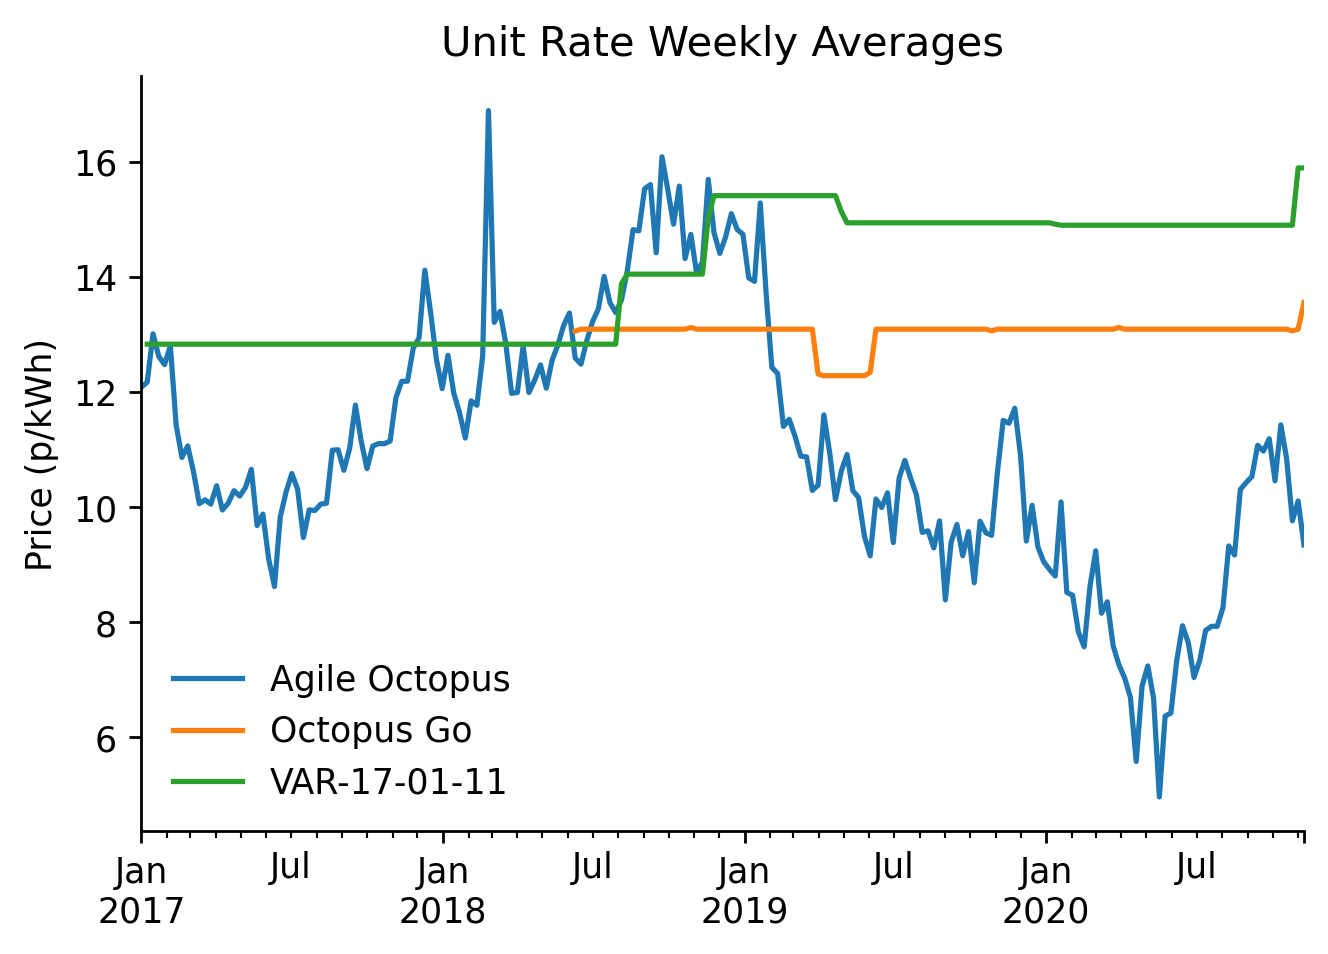

In [64]:
product_codes = ['AGILE-18-02-21', 'GO-18-06-12', 'VAR-17-01-11']
product_code_to_name = df_products['display_name'].to_dict()
df_unit_rates = pd.DataFrame()

for product_code in product_codes:
    df_unit_rates[product_code] = download_manager.create_unit_rates_s(product_code, 
                                                                       'electricity-tariffs', 
                                                                       f'E-1R-{product_code}-C', 
                                                                       'standard-unit-rates')

df_unit_rates_weekly_avg = (df_unit_rates
                            .resample('7D')
                            .mean()
                            .rename(columns=product_code_to_name)
                            .iloc[:-4, :] # <- The next 4wk avg is estimated for each tariff
                           )

# Plotting
fig, ax = plt.subplots(dpi=250)
fig, ax = octoplot.simple_plot(df_unit_rates_weekly_avg, ylabel='Price (p/kWh)', ax=ax)
ax.set_title('Unit Rate Weekly Averages')

<br>

### More Complex Requests

As well as the required arguments which appear in the end-point function signatures, there are also a number of parameters which can be passed as kwargs to each of them - these are listed in the docstrings. In this example we'll specify a time-period to query electricity consumption between.

<AxesSubplot:xlabel='interval_start'>

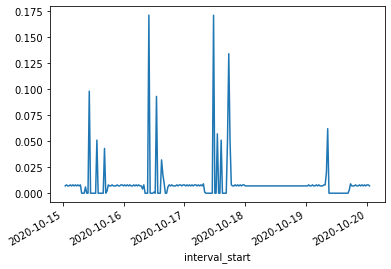

In [23]:
s_elec_consumption = download_manager.create_elec_consumption_s(period_from='2020-10-15T00:00:00Z', 
                                                                period_to='2020-10-20T00:00:00Z')

s_elec_consumption.plot()